In [39]:
! pip install rasterio matplotlib -q
import rasterio
from rasterio.plot import show, show_hist
from rasterio.windows import Window
import matplotlib.pyplot as plt
import numpy as np
import os

! ls -l ./data # target files in data folder

total 92
-rw-rw-r-- 1 jovyan users 56866 Apr 22 03:09 nlcd.tif
-rw-rw-r-- 1 jovyan users 33922 Apr 22 03:09 wui.tif


In [40]:
base_path = "./data"

# DATA PREPROCESSING (SHAPE, CRS, TRANSFORM, ETC.)

In [41]:
NLCD_path = base_path + '/nlcd.tif'
WUI_path = base_path + '/wui.tif'
with rasterio.open(NLCD_path) as src:
  print(src.profile)
  print(src.bounds)
  NLCD = src.read()

with rasterio.open(WUI_path) as src:
  print(src.profile)
  print(src.bounds)
  WUI = src.read()

# show(NLCD)
# show(WUI)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1056, 'height': 816, 'count': 4, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockysize': 8, 'tiled': False, 'compress': 'deflate', 'interleave': 'pixel'}
BoundingBox(left=0.0, bottom=816.0, right=1056.0, top=0.0)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1056, 'height': 816, 'count': 4, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockysize': 8, 'tiled': False, 'compress': 'deflate', 'interleave': 'pixel'}
BoundingBox(left=0.0, bottom=816.0, right=1056.0, top=0.0)


/opt/conda/lib/python3.11/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


/opt/conda/lib/python3.11/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


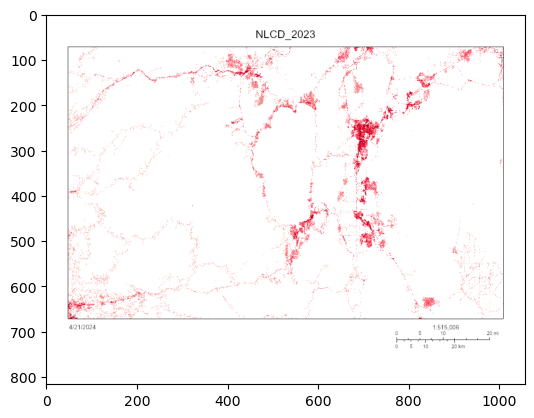

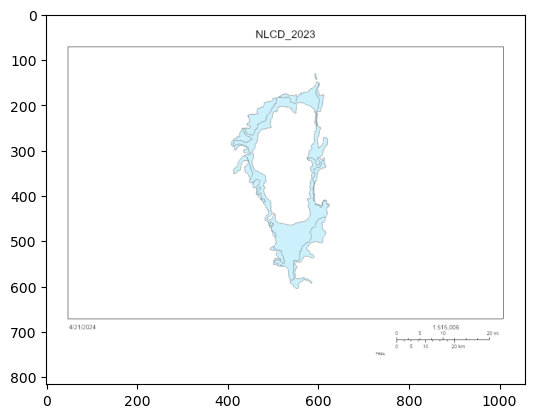

<Axes: >

In [42]:
# Open the original raster
input_raster_path = NLCD_path
output_path = 'refitted.tif'
shift_pixels = 1  # Number of pixels to shift upwards

with rasterio.open(input_raster_path) as src:
    data = src.read()  # Reading all bands
    meta = src.meta  # Copying all metadata from the source raster

    # Write the data to the new raster using the same metadata
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(data)

with rasterio.open(output_path) as src:
  show(src)

show(WUI)

In [43]:
# Read NLCD and WUI rasters
with rasterio.open(output_path) as nlcd_src:
    nlcd_data = nlcd_src.read()
    nlcd_meta = nlcd_src.meta

with rasterio.open(WUI_path) as wui_src:
    wui_data = wui_src.read()

# Change the Driver
nlcd_meta.update({"driver": "GTiff"})

# Create combined feature array
raw = nlcd_data.copy()
combined_features = raw.reshape(nlcd_data.shape)

# Apply Intersection Mask
combined_features[wui_data == 255] = 255

# Update the crs to a default Google Maps-like CRS
default_crs = 'EPSG:3857'  # Web Mercator CRS (a default crs)
nlcd_meta.update({'crs': default_crs})

# New raster path
combined_path = "combined_raster.tif"

# Write the new raster
with rasterio.open(combined_path, "w", **nlcd_meta) as dst:
    dst.write(combined_features)

# Display the raster
# with rasterio.open(combined_path) as src:
#     print(src.meta)
#     show(src, title="Combined Raster")
#     for i in range(1, src.count + 1):
#         show(src.read(i), title=f"Band:{i}", cmap="viridis_r")

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 325, 'height': 550, 'count': 4, 'crs': CRS.from_epsg(3857), 'transform': Affine(1.0, 0.0, 370.0,
       0.0, 1.0, 100.0)}


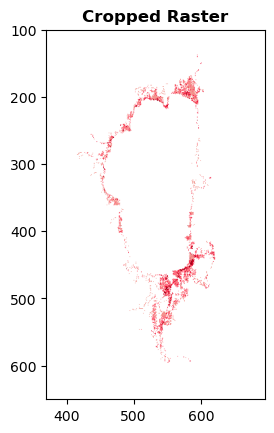

In [44]:
# Path to your raster file
raster_path = combined_path

# Define the window: Window(col_off, row_off, width, height)
# For example, to crop the top left quarter
window = Window(370, 100, 325, 550)  # Adjust these values as needed

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the data from the defined window
    cropped_data = src.read(window=window)

    # Update the metadata for the output file
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": window.height,
        "width": window.width,
        "transform": rasterio.windows.transform(window, src.transform)
    })

    # Path for the output cropped raster
    output_raster_path = "cropped_raster.tif"

    # Write the cropped raster to a new file
    with rasterio.open(output_raster_path, "w", **out_meta) as dest:
        dest.write(cropped_data)

# Display the cropped raster
with rasterio.open(output_raster_path) as src:
    print(src.meta)
    show(src, title="Cropped Raster")

In [45]:
# Open your .tiff image
with rasterio.open(output_raster_path, 'r') as src:
  # Read all bands and concatenate them
  bands = [src.read(i + 1, out_dtype=np.intc) for i in range(src.count)]
  stacked_meta = meta

  # Stack bands along the third dimension (channels last)
  img = np.stack(bands, axis=-1)

In [46]:
from matplotlib.colors import ListedColormap

# Define a colormap: You can customize these colors
cmap = ListedColormap(['black', 'blue', 'green', 'red'])

In [47]:
print("img:", img.shape)
print("img_data:", img_data.shape)

red_channel = img_data[:,:,0]
filtered_red_channel = np.where(red_channel == 255, 0, red_channel) # filter out white pixels
print("filtered_red_channel:", filtered_red_channel.shape)

# plt.figure(figsize=(8, 8))
# plt.title('img_data')
# plt.imshow(filtered_red_channel, cmap='Reds')
# plt.colorbar() 
# plt.show()

img: (550, 325, 4)
img_data: (550, 325, 4)
filtered_red_channel: (550, 325)


In [48]:
# squash red channel to 1 dimensional vector for model ingestion
filtered_red_channel_1d = filtered_red_channel.reshape(-1, 1)
print("filtered_red_channel_1d", filtered_red_channel_1d.shape)

filtered_red_channel_1d (178750, 1)


# Feature Scaling

normalized_1d: (178750, 1)
normalized_2d: (550, 325)
unique: [0.         0.65702479 0.97933884 1.        ]


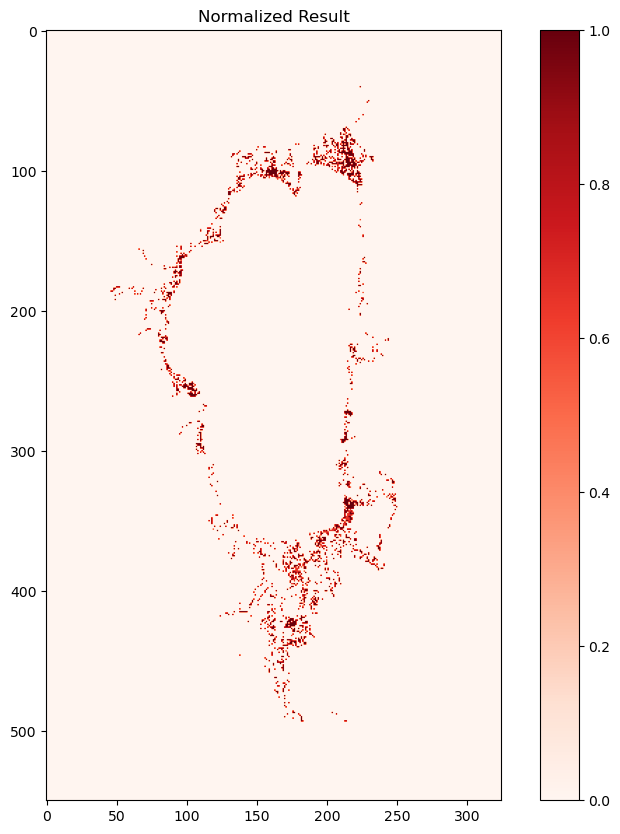

In [49]:
from sklearn.preprocessing import MinMaxScaler
# non_zero_red_pixels = filtered_red_channel_1d[filtered_red_channel_1d != 0]

scaler = MinMaxScaler()

# Normalize the red channel
normalized_1d = scaler.fit_transform(filtered_red_channel_1d)
print("normalized_1d:", normalized_1d.shape)

normalized_2d = normalized_1d.reshape(filtered_red_channel.shape)
print("normalized_2d:", normalized_2d.shape)

print("unique:", np.unique(normalized_2d))

# Display the clustered image
plt.figure(figsize=(10, 10))
plt.imshow(normalized_2d, cmap='Reds')
plt.title("Normalized Result")
plt.colorbar()
plt.show()

# Elbow Method (Optimal K-value)

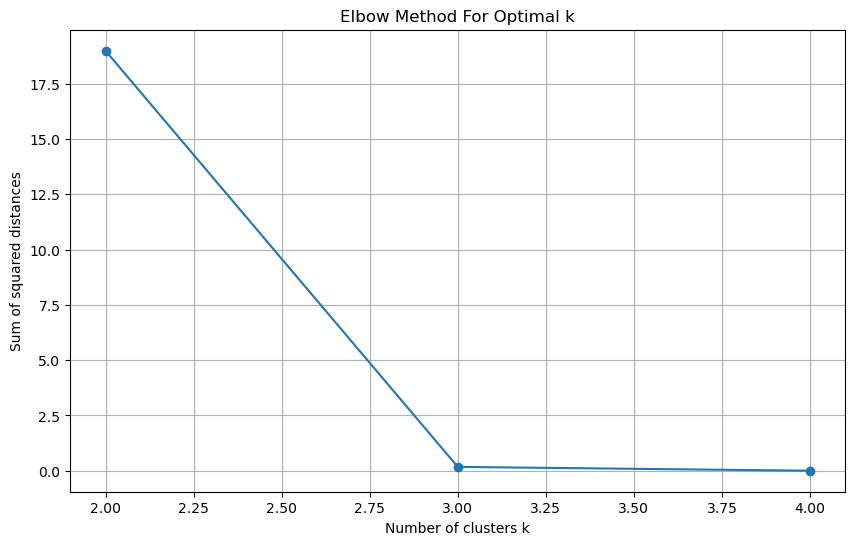

In [50]:
from sklearn.cluster import KMeans

# Range of clusters to try
k_values = range(2, 5)
ssd = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(normalized_1d)
    ssd.append(kmeans.inertia_)  # Inertia: Sum of squared distances of samples to their closest cluster center

plt.figure(figsize=(10, 6))
plt.plot(k_values, ssd, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.show()

# K-Means Spectral Clustering

cluster_centers: (2, 2)
cluster_labels_2d: (550, 325)
Center coords: 2.3973878437999474e-15 0.9793388429752099
Center coords: 0.6570247933884301 1.0000000000000022
SCALE: [0 1 2 3]


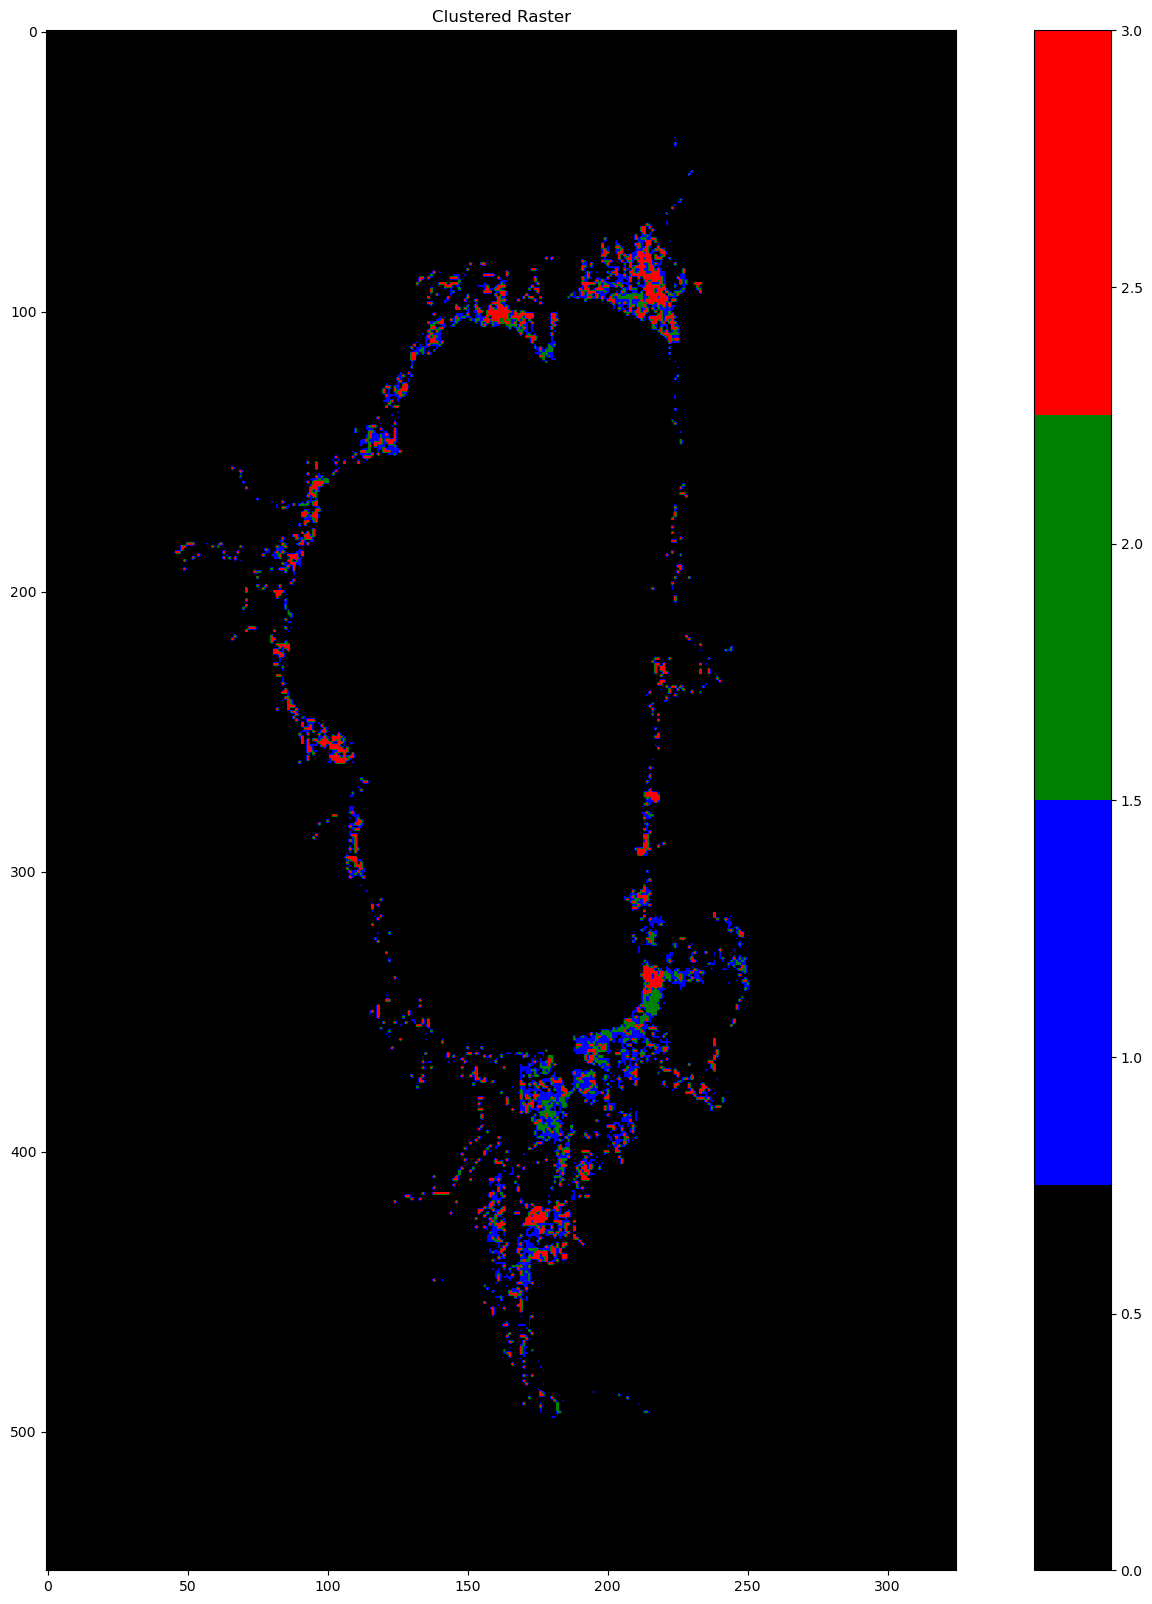

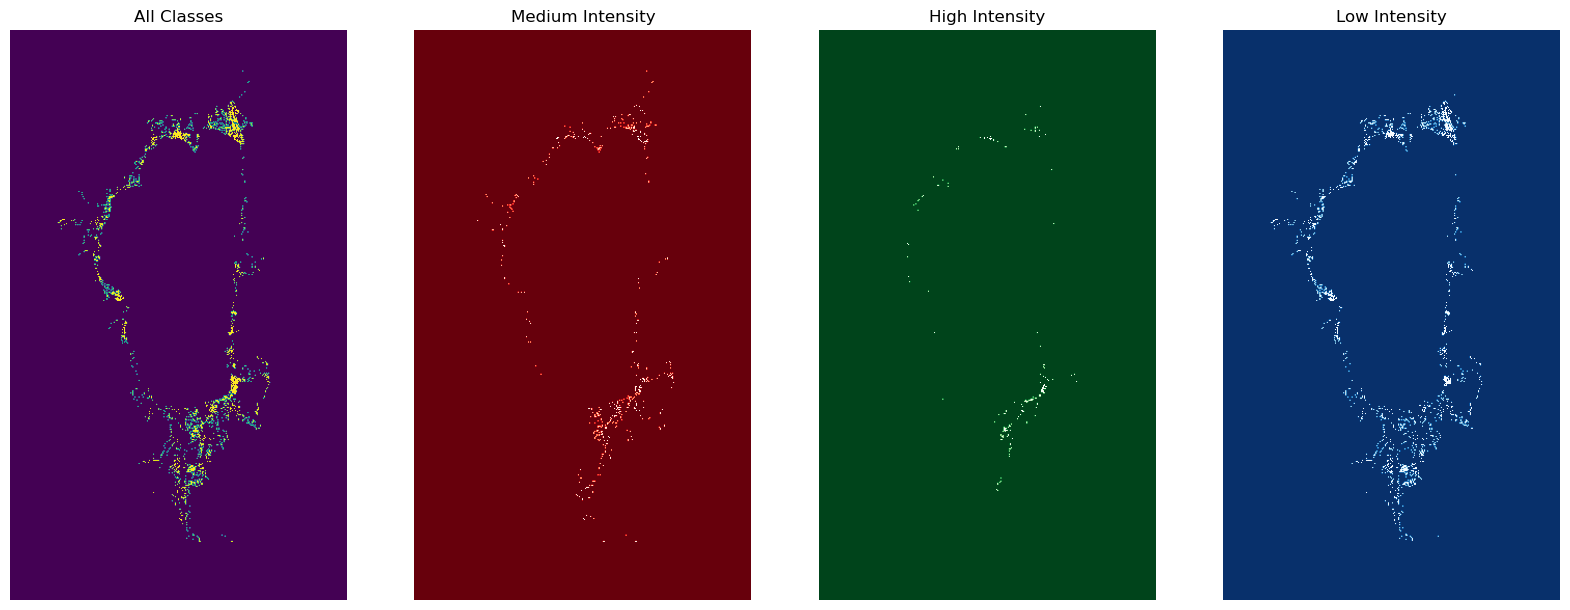

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [51]:
n = 4
kmeans = KMeans(n_clusters=n, n_init='auto')
kmeans.fit(normalized_1d)

cluster_centers = kmeans.cluster_centers_.reshape(2, -1)
print("cluster_centers:", cluster_centers.shape)

cluster_labels = kmeans.labels_
cluster_labels_2d = cluster_labels.reshape(filtered_red_channel.shape)
print("cluster_labels_2d:", cluster_labels_2d.shape)

cluster_image = np.zeros_like(filtered_red_channel)
for label in np.unique(cluster_labels_2d):
    cluster_image[cluster_labels_2d == label] = label


# Mark cluster centers in the cluster_image array
for i in range(len(cluster_centers)):
    center_x, center_y = cluster_centers[i][0], cluster_centers[i][1]
    # center_x, center_y = int(center[i][j]), int(center[i][j])
    print("Center coords:", center_x, center_y)
    # cluster_image[center_y - 100:center_y + 200, center_x - 100:center_x + 200] = 4  # Mark a 3x3 area around the center

print("SCALE:", np.unique(cluster_image))

plt.figure(figsize=(20, 20))
plt.title('Clustered Raster')
plt.imshow(img_cl, cmap=cmap)
plt.colorbar()  # To show the color scale
plt.show()

colors = ['viridis_r', 'Reds_r', 'Greens_r', 'Blues_r']
titles = ['All Classes', 'Medium Intensity', 'High Intensity', 'Low Intensity']
fig, axs = plt.subplots(1, n, figsize=(20, 20))
for clas in range(0, n):
    separate = np.zeros_like(filtered_red_channel)
    separate[cluster_labels_2d == clas] = label

    plt.figure(figsize=(10, 10))
    axs[clas].imshow(separate, cmap=colors[clas])
    axs[clas].set_title(titles[clas])
    axs[clas].axis('off')

plt.show()
plt.savefig('result.png')